In [4]:
import numpy as np
import pylops
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [5]:
nt = 1081
ns = 300
nr = 301

D_aftmask = np.load('/Users/jingmingruan/Desktop/MSc/3d/Script/D_aftmask.npy')
fre_shift = np.load('/Users/jingmingruan/Desktop/MSc/3d/Script/fre_shift.npy')

# D1_r_re = np.load('/Users/jingmingruan/Desktop/MSc/3d/Script/D1_r_re.npy')
# D1_s_re = np.load('/Users/jingmingruan/Desktop/MSc/3d/Script/D1_s_re.npy')
# D2_r_re = np.load('/Users/jingmingruan/Desktop/MSc/3d/Script/D2_r_re.npy')
# D2_s_re = np.load('/Users/jingmingruan/Desktop/MSc/3d/Script/D2_s_re.npy')

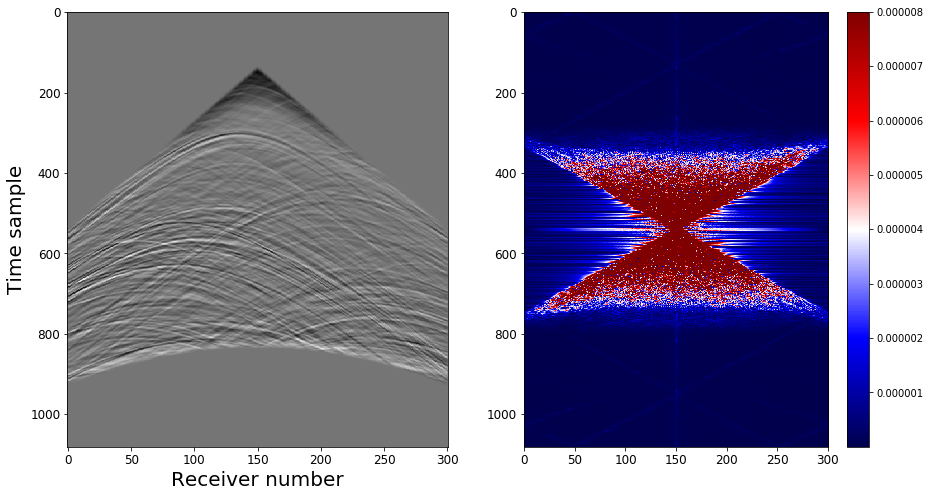

In [31]:
num = 150
fig = plt.figure(figsize = (15,8))
gs = gridspec.GridSpec(1, 2)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.imshow(np.real(D_aftmask[:,:,num]),cmap='gray',aspect='auto')
ax1.set_xlabel('Receiver number', fontsize=20)
ax1.set_ylabel('Time sample', fontsize=20)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 12)
im = ax2.imshow(np.abs(fre_shift[:,:,num]),cmap='seismic',aspect='auto',vmax = 8e-6)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 12)
cbar = plt.colorbar(im)
plt.show()

In [ ]:
# mask on space-time domain
dt = 0.0025
dx = 10
vel = 1490
shot = np.arange(0,nr)
mask_t = np.zeros((nt,nr,ns))

for i in range(0,end):
    loc = shot[i]
    x1 = np.arange(loc)
    x2 = np.arange(loc,nr)
    t1 = (loc-x1)*dx/(vel*dt)
    t2 = (x2-loc)*dx/(vel*dt) 
    t_vec = np.concatenate((t1,t2),axis=None) + 140

    # mask for sediment reflection
    t3 = np.sqrt(830**2 + ((loc-x1)*dx)**2/((vel*dt)**2))
    t4 = np.sqrt(830**2 + ((x2-loc)*dx)**2/((vel*dt)**2))
    t_vec2 = np.concatenate((t3,t4),axis=None)

    for k in np.arange(nr):
        mask_t[int(t_vec[k]):int(t_vec2[k]),k,i] = 1
    
    Sop_t = pylops.Smoothing2D(nsmooth=[11,3], dims=[nt, nr])
    mask_t[:,:,i] = (Sop_t*mask_t[:,:,i].flatten()).reshape(nt,nr)
    
mask_tt = pylops.Diagonal(mask_t.flatten())

In [ ]:
# mask on Fourier domain
kn=1/(2*dx)
dk=2*kn/nr

mask_fre_loc = np.zeros((nt,nr))
vel = 1450

v = np.zeros(nt)
k1 = np.zeros(nt)
k2 = np.zeros(nt)
for i in np.arange(350,540):
#     v[i] = -vn + i*dv
    k1[i] = ((-vn + i*dv)/(vel)) /dk +150
    k2[i] = ((-vn + i*dv)/(-1*vel)) /dk +150
    mask_fre_loc[i,int(k1[i]):int(k2[i])] = 1
for i in np.arange(540,730):
    k1[i] = ((-vn + i*dv)/(vel) ) /dk +150
    k2[i] = ((-vn + i*dv)/(-1*vel) ) /dk +150
    mask_fre_loc[i,int(k2[i]):int(k1[i])] = 1

mask_fre_loc = np.tile(mask_fre_loc[:,:,np.newaxis],[1,1,ns])
mask_fre_loc = np.fft.ifftshift(mask_fre_loc.reshape(nt,nr,ns))
mask_fre = pylops.Diagonal(mask_fre_loc)

In [ ]:
# derivatives
dx=10
krn=1/(2*dx)
krs = np.fft.fftfreq(nr, d=dx)

ds =10
ksn = 1/(2*ds)
kss = np.fft.fftfreq(ns, d=ds)

dt=0.0025
fn=1/(2*dt);

first_deriv = np.zeros((nr,ns))
second_deriv = np.zeros((nr,ns))

mat_first_r = 1j*2*np.pi*krs
mat_first_s = 1j*2*np.pi*kss
mat_second_r = -(2*np.pi*krs)**2
mat_second_s = -(2*np.pi*kss)**2

fir_deriv_r = np.tile(mat_first_r[np.newaxis, :,np.newaxis ], [nt, 1, ns])
fir_deriv_s = np.tile(mat_first_s[np.newaxis, np.newaxis, : ], [nt, nr, 1])
sec_deriv_r = np.tile(mat_second_r[np.newaxis, :,np.newaxis ], [nt, 1, ns])
sec_deriv_s = np.tile(mat_second_s[np.newaxis, np.newaxis, : ], [nt, nr, 1])

D1op_r = pylops.Diagonal(fir_deriv_r)
D2op_r = pylops.Diagonal(sec_deriv_r)
D1op_s = pylops.Diagonal(fir_deriv_s)
D2op_s = pylops.Diagonal(sec_deriv_s)

In [ ]:
# sampling operator
N = nt*nr*ns
cod = np.arange(0,nt*nr*ns).reshape(nt,nr,ns)
idr = np.arange(0,nr,3)
ids = np.arange(0,ns,3)

idrn = cod[:,idr,:]
idx = idrn[:,:,ids].flatten()

R = pylops.Restriction(N, idx)
D_dec = R*D_all.flatten()
D_adj = R.H*D_dec.flatten()

In [ ]:
D2_r_dec = np.real(R*(D2_r_re.flatten()))
D1_r_dec = np.real(R*(D1_r_re.flatten()))
D2_s_dec = np.real(R*(D2_s_re.flatten()))
D1_s_dec = np.real(R*(D1_s_re.flatten()))
D_dec = R*ND.flatten()

Forward = pylops.VStack([R*mask_tt*F.H*mask_fre, 
                         R*mask_tt*F.H*D1op_r*mask_fre, 
                         R*mask_tt*F.H*D1op_s*mask_fre,
                         R*mask_tt*F.H*D2op_r*mask_fre,
                         R*mask_tt*F.H*D2op_s*mask_fre])

rhs = np.concatenate((D_dec, 
                      D1_r_dec, 
                      D1_s_dec,
                      D2_r_dec,
                      D2_s_dec), axis=0)
xinv_ = \
    pylops.optimization.leastsquares.RegularizedInversion(Forward, [], rhs, 
                                                          **dict(damp=0, iter_lim=600, show=0))

xinv = scail*mask_tt*F.H*mask_fre*xinv_

xinv = np.real(xinv.reshape(nt,nr,ns))
xinv_fre = np.fft.fftshift(np.fft.fftn(xinv))

relative = np.abs((xinv - D_aftmask) / np.amax(D_aftmask))
relative_fre = np.abs((xinv_fre - fre_shift) / np.amax(fre_shift))

np.save('xinv', xinv)
np.save('relative', relative)
np.save('relative_fre', relative_fre)